In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import scipy
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils

import bilby


In [2]:
torch.cuda.is_available()

True

In [2]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
h5filename = root_dir + 'gw_fd_8D_q7a5_2N2000_Pv2v4P_downsampled.h5'

Ngw = gwutils.get_gwfdh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

random_index = np.random.permutation(Ngw)
train_index = random_index[:Ntrain]
test_index = random_index[Ntrain:Ntrain+Ntest]
valid_index = random_index[-Nvalid:]

gw_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=train_index)
gw_test_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=test_index)
gw_valid_dataset = gwutils.GWDatasetFDMultimodel(h5file=h5filename, indcies=valid_index)


In [3]:
gw_dataset.n_samples

700

In [4]:
train_label = 'IMRPv2EOBv4P_q7a5fd_2N2000'

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [11]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.3, b=0.5), targets_getter=GetRandomIndcs(a=0.3, b=0.5), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [12]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=1,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,612


In [27]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=True,
    criterion=CNPFLoss,
    chckpnt_dirname="/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/",
    device="cuda",
    lr=5e-5,
    decay_lr=10,
    seed=123,
    batch_size=4,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=50,
    **KWARGS
)




--- Training IMRPv2EOBv4P_q7a5fd_2N2000/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
     49    -5137.2548    -3895.5186     +  26.0809


     50    -4996.4271    -4251.7717     +  24.7289


     51    -5277.9081    -4738.7230     +  25.5938


     52    -5258.7748    -3908.1568        24.4481


     53    -5218.4772    -4561.5514        25.3187


     54    -5314.9689    -4226.3677        24.7549


     55    -5293.3763    -3931.2677        24.7883


     56    -5284.2320    -4773.5816     +  24.1876


     57    -5133.1382    -4592.1362        20.6294


     58    -5271.4305    -4352.0309        23.8049


     59    -5227.2707    -3370.6058        25.8262


     60    -5216.7685    -4884.0652     +  25.9845


     61    -5110.5558    -2815.2806        24.6416


     62    -5336.6726    -5019.6179     +  24.4295


     63    -5444.0027    -4721.4647        25.2581


     64    -5499.0214    -4384.6721        25.3813


     65    -5350.2597    -4988.4095        23.3452


     66    -5381.0989    -4862.9865        27.1408


     67    -5362.4592    -4360.8740        24.7686


     68    -5446.2679    -4127.8980        26.2338


     69    -5410.9126    -2990.1554        23.3854


     70    -5362.9786    -4421.2727        24.9119


     71    -5460.0045    -4826.8357        24.6833


     72    -5484.8551    -4777.3053        22.0125


     73    -5434.8985    -4237.3643        26.5837


     74    -5420.1550    -3652.9361        24.6145


     75    -5433.6253    -4391.0271        24.7527


     76    -5443.8643    -5139.8380     +  25.1629


     77    -5442.7586    -4065.0041        28.6991


     78    -5514.2726    -4280.4213        26.1854


     79    -5452.0307    -5002.0027        27.4302


     80    -5488.2388    -4943.8898        27.9422


     81    -5416.6363    -5250.0007     +  25.3707


     82    -5490.7582    -4506.5432        25.2896


     83    -5490.5425    -4724.9363        23.0504


     84    -5458.1116    -5280.8972     +  27.1575


     85    -5489.9182    -4718.9438        24.3235


     86    -5567.7012    -3524.6551        24.2839


     87    -5402.1292    -5294.9571     +  27.6773


     88    -5476.4006    -5111.5371        25.2703


     89    -5399.2643    -4447.0161        25.0173


     90    -5490.6528    -4857.5486        27.5814


     91    -5446.9980    -4574.1207        19.8180


     92    -5588.2577    -4085.2655        25.2303


     93    -5516.3533    -4894.8598        25.1110


     94    -5576.7702    -5156.9964        27.3649


     95    -5417.3658    -4780.3667        25.6496


     96    -5545.9099    -5175.3659        25.2592


     97    -5648.1559    -5317.3969     +  24.6281


     98    -5639.8939    -5273.1511        21.5166


IMRPv2EOBv4P_q7a5fd_2N2000/ConvCNP/run_0 | best epoch: 97 | train loss: -5648.1559 | valid loss: -5317.3969 | test log likelihood: 3739.78


In [28]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [29]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [37]:
look_approx = 'IMRPhenomPv2'
look_index = 2


x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]

In [38]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)

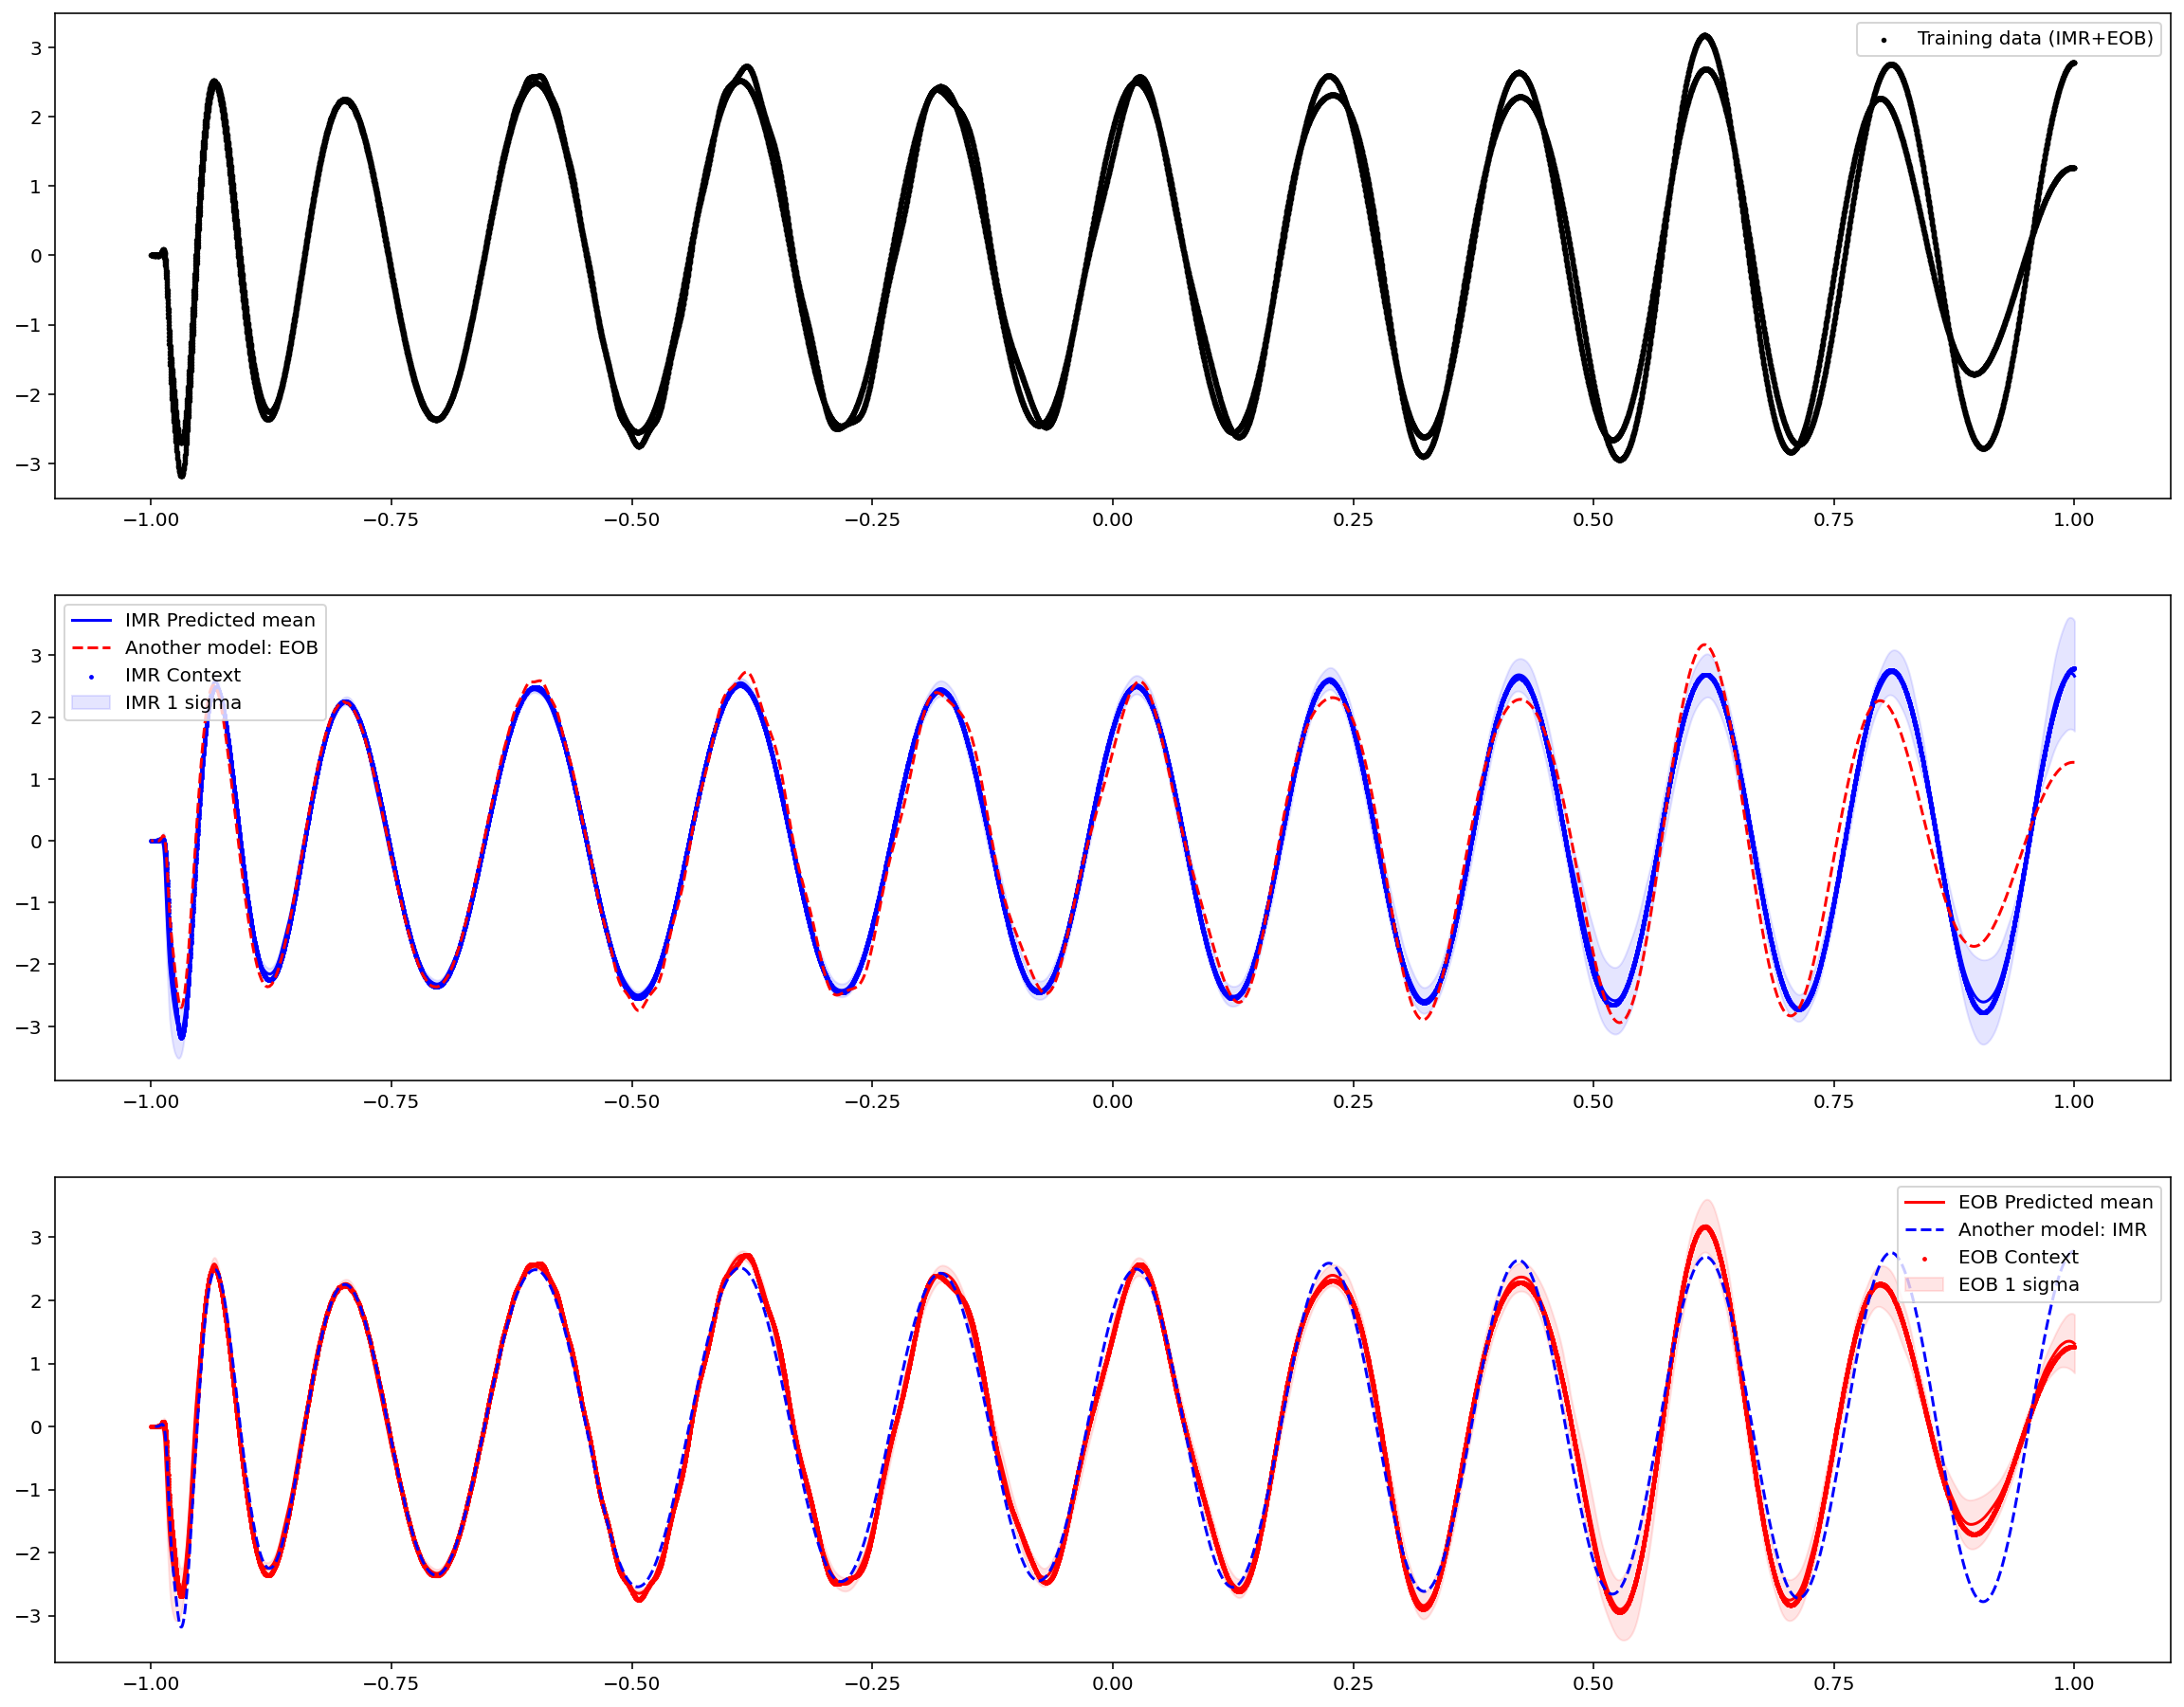

In [39]:
plt.figure(figsize=(20,16))
plt.subplot(3,1,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()

plt.subplot(3,1,2)
plt.scatter(x_test_context_imr, y_test_context_imr, label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr, label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr-std_imr, y2=mean_imr+std_imr, label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob, label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(3,1,3)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()

#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

In [29]:
def test_plots(dataset, model, testnum=10, subplotshape=(5,2), figsize=(20,20) ):
    plt.figure(figsize=figsize)
    for testindex in range(testnum):
        x_test, y_test = dataset[testindex]

        len_data = len(x_test)
        len_context = int(len_data*1)
        context_index = np.sort( np.random.permutation(len_data)[:len_context] )
        target_index = np.arange(len_data)

        x_test_context = x_test[context_index]
        y_test_context = y_test[context_index]

        x_test_target = x_test[target_index]
        x_yest_target = y_test[target_index]

        nsample = 1
        mean, std = gwutils.get_predictions(model, x_test_context.unsqueeze(0), y_test_context.unsqueeze(0),
                                    x_test_target.unsqueeze(0), nsample)

        plt.subplot(subplotshape[0],subplotshape[1], testindex+1)
        plt.plot(x_test, y_test, label='Target function', color='k')
        plt.scatter(x_test_context, y_test_context, label='Context', color='b',s=8)
        plt.plot(x_test_target, mean, label='Predicted mean', color='r',linestyle='--')
        plt.fill_between(x=x_test_target.squeeze(), y1=mean-std, y2=mean+std, label='1 sigma', alpha=0.1, color='r')
        plt.text(x=-0.5,y=-6, s=f"test id: {testindex}")
        if testindex in [0,1]:
            plt.legend()
    
    plt.show()

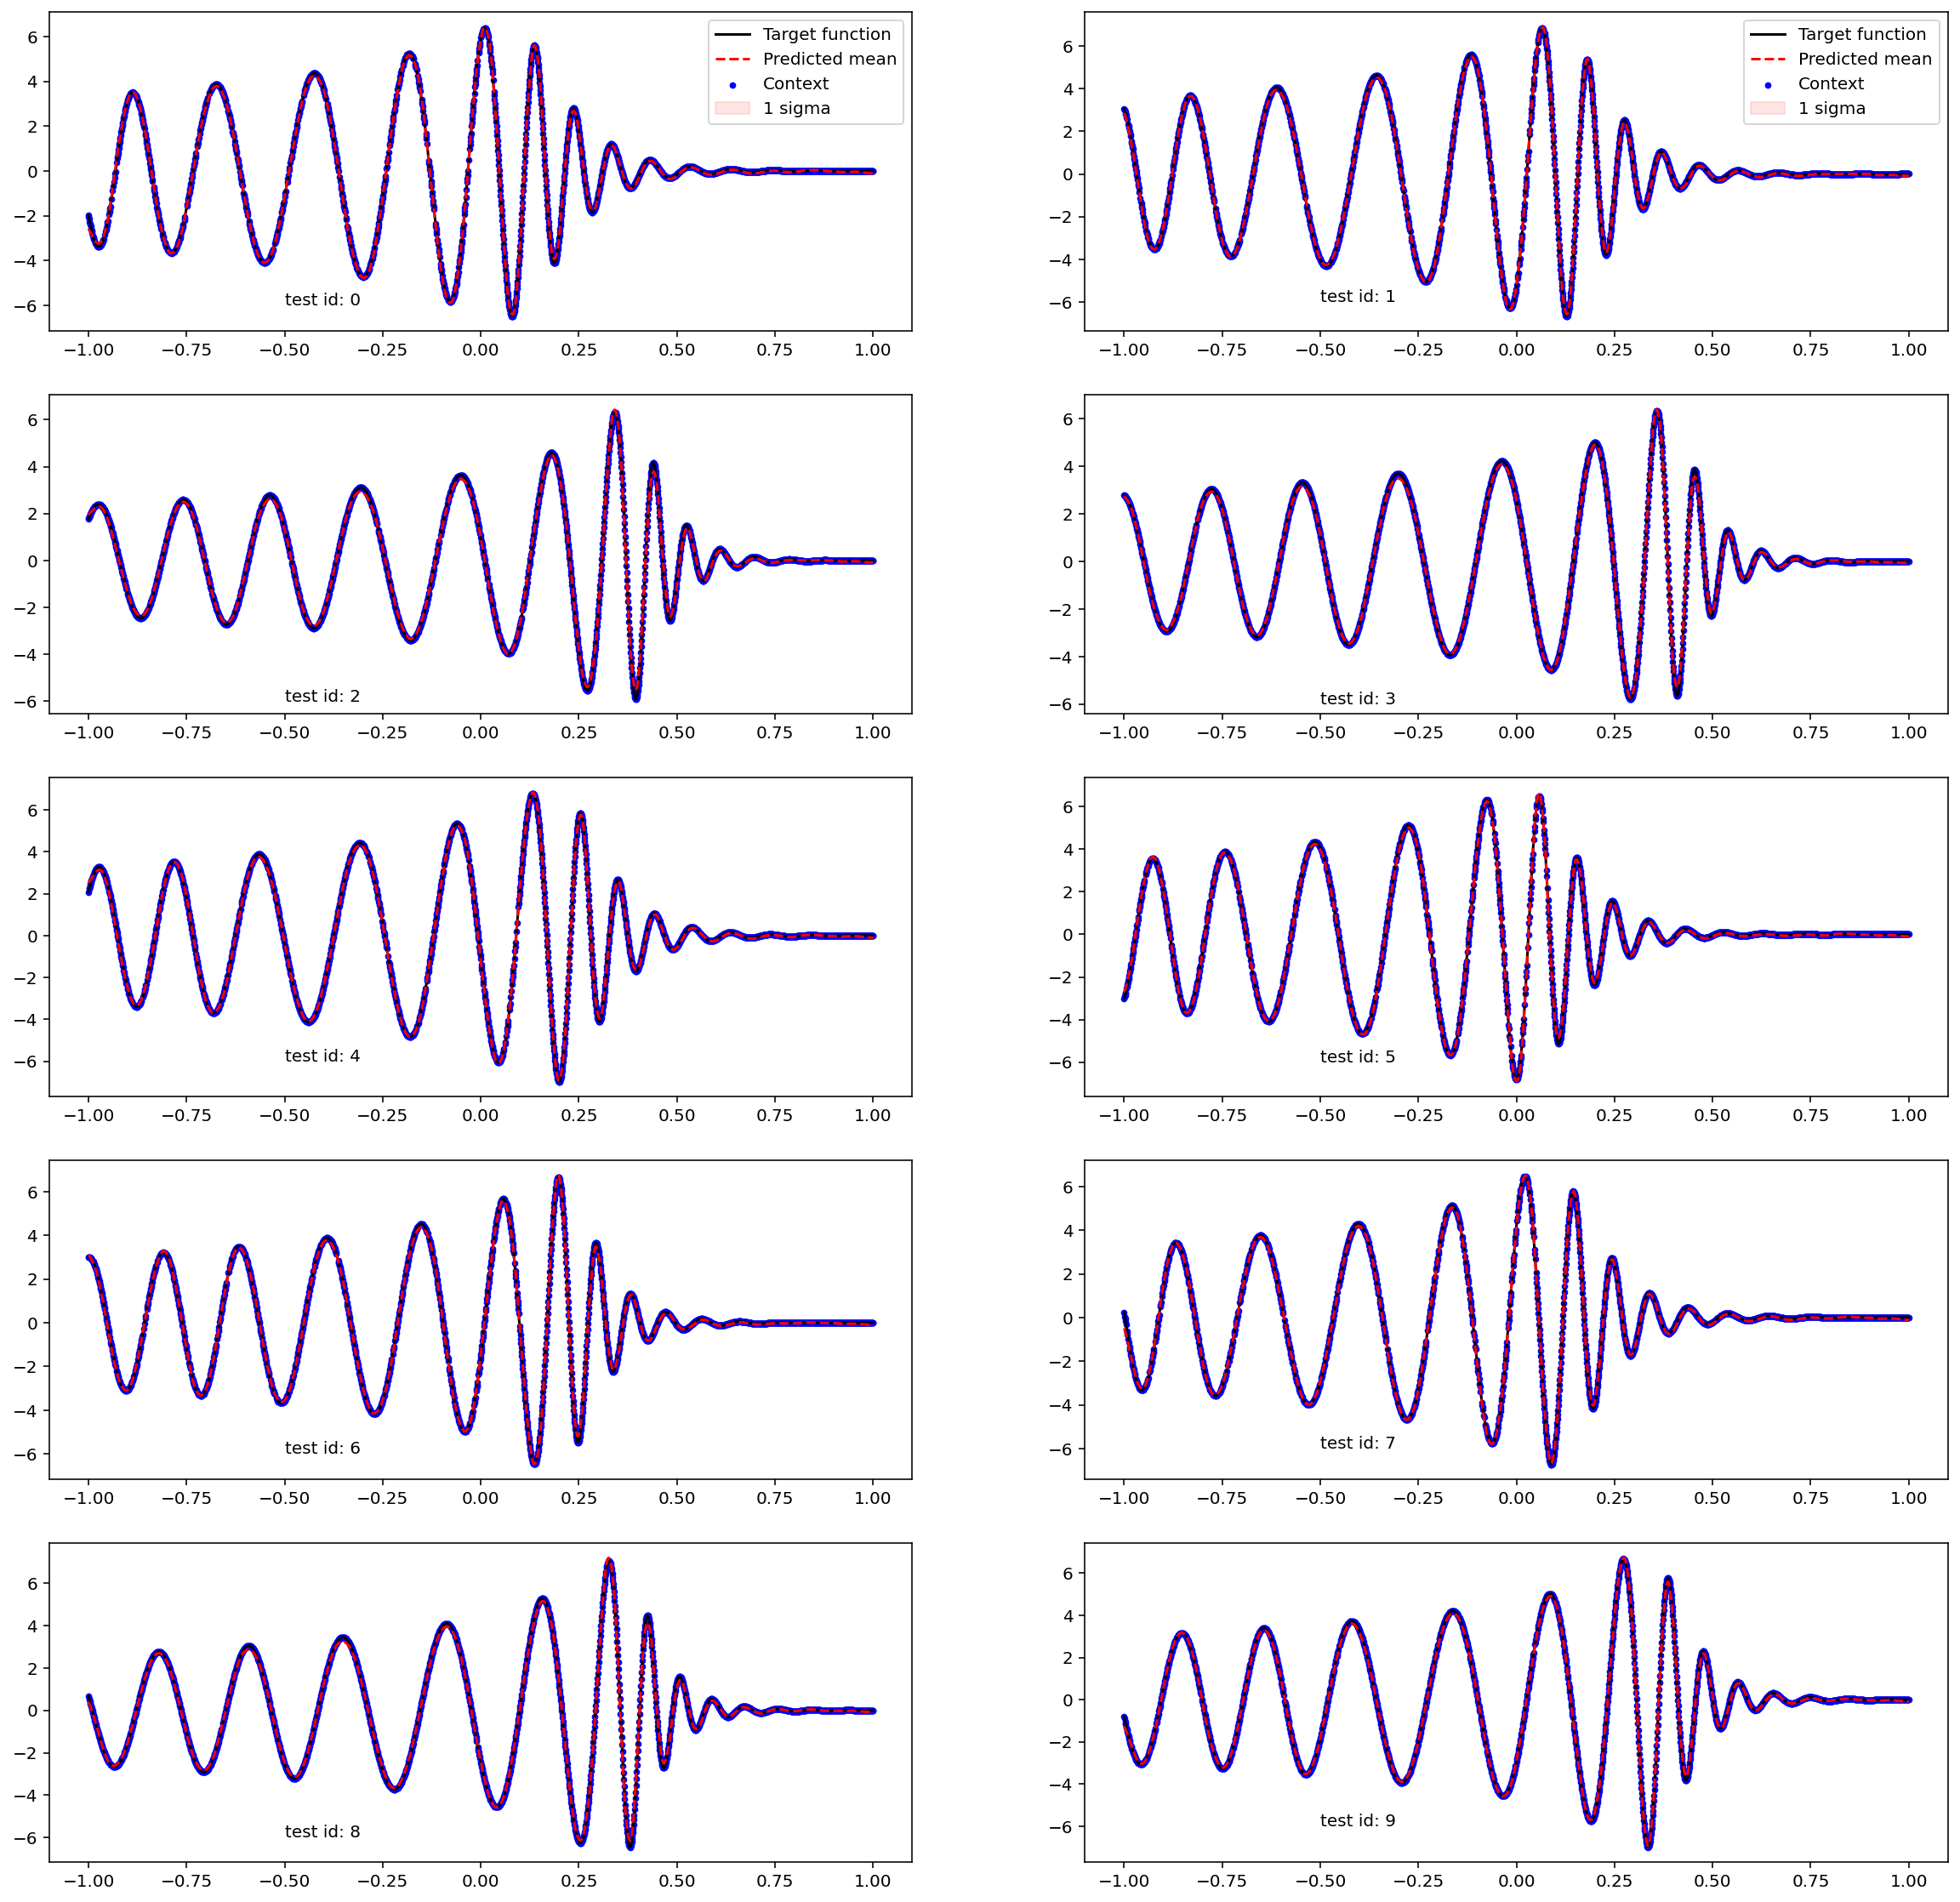

In [30]:
test_plots(dataset=gw_test_datasets[f'{train_label}'], model=model_pv2v4p_7d)